In [1]:
import os
import sys
import shutil
import numpy as np
import tensorflow as tf
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.applications import MobileNetV2
from tensorflow.keras.layers import Dense, GlobalAveragePooling2D
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report
import cv2
from tensorflow.keras.preprocessing.image import img_to_array, load_img
from tensorflow.keras import models


In [2]:
dataset_path = "./Test_Images"
batch_size = 16
epochs = 50


In [3]:
train_dir = "./Test_Images/train"
val_dir = "./Test_Images/val"
test_dir = "./Test_Images/test"

# Create directories for training, validation, and test data
os.makedirs(train_dir, exist_ok=True)
os.makedirs(val_dir, exist_ok=True)
os.makedirs(test_dir, exist_ok=True)

# Get paths to all image files in the dataset
image_paths = []
class_labels = os.listdir(dataset_path)
for label in class_labels:
    class_path = os.path.join(dataset_path, label)
    if os.path.isdir(class_path):
        image_paths.extend([os.path.join(class_path, fname) for fname in os.listdir(class_path)])

train_paths, temp_paths = train_test_split(image_paths, test_size=0.2, random_state=42) 
val_paths, test_paths = train_test_split(temp_paths, test_size=0.5, random_state=42)

def move_images(image_paths, dest_dir):
    """
    Move images to their respective class directories.
    """
    for img_path in image_paths:
        if os.path.isfile(img_path):
            label = img_path.split('/')[-2]
            class_dest_dir = os.path.join(dest_dir, label)
            os.makedirs(class_dest_dir, exist_ok=True)
            shutil.copy(img_path, class_dest_dir)

# Move images to their respective directories
move_images(train_paths, train_dir)
move_images(val_paths, val_dir)
move_images(test_paths, test_dir)


In [4]:
print(len(train_paths))
print(len(val_paths))
print(len(test_paths))

2477
310
310


In [5]:
class SuppressTensorFlowOutput:
    def __enter__(self):
        self._original_stdout = sys.stdout
        sys.stdout = open(os.devnull, 'w')
        return self

    def __exit__(self, exc_type, exc_value, traceback):
        sys.stdout.close()
        sys.stdout = self._original_stdout

with SuppressTensorFlowOutput():
    train_datagen = ImageDataGenerator(rescale=1./255)
    train_generator = train_datagen.flow_from_directory(
        train_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )

with SuppressTensorFlowOutput():
    validation_datagen = ImageDataGenerator(rescale=1./255)
    validation_generator = validation_datagen.flow_from_directory(
        val_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )

with SuppressTensorFlowOutput():
    test_datagen = ImageDataGenerator(rescale=1./255)
    test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(128, 128),
        batch_size=batch_size,
        class_mode='categorical'
    )


In [6]:
base_model = MobileNetV2(input_shape=(128, 128, 3), include_top=False, weights='imagenet')
base_model.trainable = False

x = base_model.output
x = GlobalAveragePooling2D()(x)
x = Dense(128, activation='relu')(x)
x = Dense(train_generator.num_classes, activation='softmax')(x)

model = Model(inputs=base_model.input, outputs=x)

model.compile(optimizer=Adam(learning_rate=0.001), loss='categorical_crossentropy', metrics=['accuracy'])


In [7]:
history = model.fit(
    train_generator,
    steps_per_epoch=train_generator.samples // batch_size,
    validation_data=validation_generator,
    validation_steps=validation_generator.samples // batch_size,
    epochs=epochs
)


Epoch 1/50


/Users/eolanrew/miniconda3/envs/code-demo-env/envs/data1/lib/python3.12/site-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:121: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 62ms/step - accuracy: 0.4030 - loss: 1.5014 - val_accuracy: 0.5410 - val_loss: 1.1987
Epoch 2/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 689us/step - accuracy: 0.4375 - loss: 1.3050 - val_accuracy: 0.5000 - val_loss: 1.0844
Epoch 3/50


2024-11-13 14:00:51.126717: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
/Users/eolanrew/miniconda3/envs/code-demo-env/envs/data1/lib/python3.12/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(value)
2024-11-13 14:00:51.192047: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 65ms/step - accuracy: 0.5829 - loss: 1.0901 - val_accuracy: 0.5918 - val_loss: 1.0902
Epoch 4/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 433us/step - accuracy: 0.5000 - loss: 1.3667 - val_accuracy: 0.3571 - val_loss: 1.3692
Epoch 5/50


2024-11-13 14:01:02.754128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:01:02.815128: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 62ms/step - accuracy: 0.6344 - loss: 0.9714 - val_accuracy: 0.5957 - val_loss: 1.0669
Epoch 6/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 391us/step - accuracy: 0.6250 - loss: 1.1652 - val_accuracy: 0.7857 - val_loss: 0.8390
Epoch 7/50


2024-11-13 14:01:13.785455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:01:13.840584: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 66ms/step - accuracy: 0.7024 - loss: 0.7854 - val_accuracy: 0.6328 - val_loss: 0.9506
Epoch 8/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 395us/step - accuracy: 0.7500 - loss: 0.6734 - val_accuracy: 0.6429 - val_loss: 0.8620
Epoch 9/50


2024-11-13 14:01:25.411521: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:01:25.467716: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 66ms/step - accuracy: 0.7424 - loss: 0.7090 - val_accuracy: 0.6738 - val_loss: 0.9257
Epoch 10/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.6250 - loss: 0.8282 - val_accuracy: 0.7857 - val_loss: 0.5752
Epoch 11/50


2024-11-13 14:01:37.187789: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:01:37.244067: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 67ms/step - accuracy: 0.7765 - loss: 0.6189 - val_accuracy: 0.6367 - val_loss: 0.9483
Epoch 12/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 374us/step - accuracy: 0.6875 - loss: 0.5160 - val_accuracy: 0.7857 - val_loss: 0.8045
Epoch 13/50


2024-11-13 14:01:49.115571: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:01:49.168416: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.8019 - loss: 0.5376 - val_accuracy: 0.6582 - val_loss: 0.9243
Epoch 14/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 379us/step - accuracy: 0.7500 - loss: 0.8070 - val_accuracy: 0.6429 - val_loss: 1.1381
Epoch 15/50


2024-11-13 14:02:01.221740: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:02:01.275471: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8278 - loss: 0.4837 - val_accuracy: 0.7227 - val_loss: 0.9067
Epoch 16/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 393us/step - accuracy: 0.9375 - loss: 0.2733 - val_accuracy: 0.7143 - val_loss: 0.8258
Epoch 17/50


2024-11-13 14:02:12.452116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:02:12.507957: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8675 - loss: 0.3902 - val_accuracy: 0.6797 - val_loss: 1.0859
Epoch 18/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 365us/step - accuracy: 0.7500 - loss: 0.5663 - val_accuracy: 0.5714 - val_loss: 0.8398
Epoch 19/50


2024-11-13 14:02:23.620745: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:02:23.670728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8794 - loss: 0.3434 - val_accuracy: 0.7031 - val_loss: 0.8813
Epoch 20/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 368us/step - accuracy: 0.9375 - loss: 0.3194 - val_accuracy: 0.9286 - val_loss: 0.3054
Epoch 21/50


2024-11-13 14:02:34.801562: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:02:34.853321: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 11s 63ms/step - accuracy: 0.8931 - loss: 0.3133 - val_accuracy: 0.7402 - val_loss: 0.8372
Epoch 22/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 363us/step - accuracy: 0.8750 - loss: 0.2796 - val_accuracy: 0.6429 - val_loss: 1.3038
Epoch 23/50


2024-11-13 14:02:46.037337: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:02:46.087892: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 68ms/step - accuracy: 0.9111 - loss: 0.2564 - val_accuracy: 0.7031 - val_loss: 0.9291
Epoch 24/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 491us/step - accuracy: 0.6875 - loss: 0.6028 - val_accuracy: 0.7143 - val_loss: 1.3836
Epoch 25/50


2024-11-13 14:02:58.087685: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:02:58.159279: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9094 - loss: 0.2518 - val_accuracy: 0.7617 - val_loss: 0.8405
Epoch 26/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.8125 - loss: 0.3138 - val_accuracy: 0.5000 - val_loss: 1.4551
Epoch 27/50


2024-11-13 14:03:11.181590: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:03:11.242730: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9217 - loss: 0.2246 - val_accuracy: 0.7363 - val_loss: 1.0140
Epoch 28/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 449us/step - accuracy: 0.9375 - loss: 0.1459 - val_accuracy: 0.7857 - val_loss: 0.5465
Epoch 29/50


2024-11-13 14:03:24.105988: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:03:24.170289: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9337 - loss: 0.1987 - val_accuracy: 0.7559 - val_loss: 0.9394
Epoch 30/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 429us/step - accuracy: 0.8750 - loss: 0.3199 - val_accuracy: 0.7143 - val_loss: 1.0138
Epoch 31/50


2024-11-13 14:03:37.529033: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:03:37.591068: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9539 - loss: 0.1584 - val_accuracy: 0.7734 - val_loss: 0.9248
Epoch 32/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 447us/step - accuracy: 0.8750 - loss: 0.3421 - val_accuracy: 0.7143 - val_loss: 1.1958
Epoch 33/50


2024-11-13 14:03:50.453022: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:03:50.517636: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9568 - loss: 0.1377 - val_accuracy: 0.7539 - val_loss: 1.0269
Epoch 34/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 437us/step - accuracy: 1.0000 - loss: 0.1263 - val_accuracy: 0.8571 - val_loss: 0.3911
Epoch 35/50


2024-11-13 14:04:03.308520: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:04:03.371405: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 83ms/step - accuracy: 0.9476 - loss: 0.1410 - val_accuracy: 0.7559 - val_loss: 1.0457
Epoch 36/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 473us/step - accuracy: 1.0000 - loss: 0.0584 - val_accuracy: 0.7143 - val_loss: 1.4509
Epoch 37/50


2024-11-13 14:04:17.931712: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:04:18.001030: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 76ms/step - accuracy: 0.9677 - loss: 0.1148 - val_accuracy: 0.7695 - val_loss: 1.0304
Epoch 38/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 448us/step - accuracy: 0.9375 - loss: 0.1653 - val_accuracy: 0.5714 - val_loss: 1.3981
Epoch 39/50


2024-11-13 14:04:31.497116: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:04:31.561455: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 12s 71ms/step - accuracy: 0.9649 - loss: 0.1070 - val_accuracy: 0.7539 - val_loss: 1.1639
Epoch 40/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 435us/step - accuracy: 0.8125 - loss: 0.3230 - val_accuracy: 0.8571 - val_loss: 0.3883
Epoch 41/50


2024-11-13 14:04:44.124596: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:04:44.188013: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9703 - loss: 0.0987 - val_accuracy: 0.7871 - val_loss: 0.9589
Epoch 42/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 478us/step - accuracy: 0.9375 - loss: 0.1111 - val_accuracy: 0.8571 - val_loss: 1.1339
Epoch 43/50


2024-11-13 14:04:57.218794: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:04:57.287916: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 77ms/step - accuracy: 0.9637 - loss: 0.1099 - val_accuracy: 0.7480 - val_loss: 1.2816
Epoch 44/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 443us/step - accuracy: 1.0000 - loss: 0.0479 - val_accuracy: 0.6429 - val_loss: 1.4375
Epoch 45/50


2024-11-13 14:05:10.940315: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:05:11.004686: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 73ms/step - accuracy: 0.9712 - loss: 0.0867 - val_accuracy: 0.7676 - val_loss: 1.1332
Epoch 46/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 481us/step - accuracy: 1.0000 - loss: 0.0047 - val_accuracy: 0.7857 - val_loss: 0.3181
Epoch 47/50


2024-11-13 14:05:23.862971: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:05:23.932764: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 13s 74ms/step - accuracy: 0.9709 - loss: 0.0804 - val_accuracy: 0.7676 - val_loss: 1.1278
Epoch 48/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 454us/step - accuracy: 0.9375 - loss: 0.2356 - val_accuracy: 0.7143 - val_loss: 0.7774
Epoch 49/50


2024-11-13 14:05:37.043221: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:05:37.109728: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


172/172 ━━━━━━━━━━━━━━━━━━━━ 14s 78ms/step - accuracy: 0.9661 - loss: 0.0955 - val_accuracy: 0.7676 - val_loss: 1.1644
Epoch 50/50
172/172 ━━━━━━━━━━━━━━━━━━━━ 0s 460us/step - accuracy: 0.9375 - loss: 0.1061 - val_accuracy: 0.8571 - val_loss: 0.7552


2024-11-13 14:05:50.778617: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]
2024-11-13 14:05:50.846159: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence
	 [[{{node IteratorGetNext}}]]


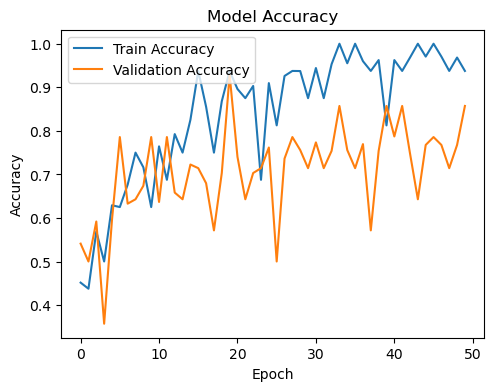

In [8]:
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend(loc='upper left')


In [9]:
# Evaluate the model on the test set
test_loss, test_accuracy = model.evaluate(test_generator, steps=test_generator.samples // batch_size)

52/52 ━━━━━━━━━━━━━━━━━━━━ 4s 73ms/step - accuracy: 0.8332 - loss: 0.8778
Test accuracy: 0.838942289352417
